<a href="https://colab.research.google.com/github/vedant75/MachineLearning/blob/main/netflix_prize_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <a id=0>0. Implementing the BellKor Solution for the Netflix Prize</a>

This notebook walks through a detailed, from-scratch implementation of the core components that powered the BellKor team's winning solution for the Netflix Prize. We will build a multi-stage recommendation model using PyTorch that closely follows their architecture:

A **Time-Aware Factorization Model (SVD):** This powerful baseline model captures global effects (user/item biases) and their evolution over time, along with latent factor interactions ("regional" effects).

A **Local Neighborhood Model:** This model is trained on the errors of the first model to capture highly specific, local patterns that the factorization model might miss.

**Blending:** The predictions from both models are combined to produce a final, more accurate rating.

**Note:**
In this notebook I will explore BellKor Solution for the Netflix Prize to recommend movies. I am using the **[netflix movie-dataset](https://www.kaggle.com/netflix-inc/netflix-prize-data/home)** for this purpose.


***
## <a id=1>1. Import Libraries</a>

In [ ]:
from IPython.display import display
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import os

In [ ]:
# To store the data
import pandas as pd

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt

# To create interactive plots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To shift lists
from collections import deque

# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
# To create sparse matrices
from scipy.sparse import coo_matrix

# To split the dataset
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

# Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import datetime
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from tqdm import tqdm
import math

***
## <a id=2>2. Load Movie-Data</a>

In [ ]:
# Load data for all movies
movie_titles = pd.read_csv('movie_titles.csv',
                           encoding = 'ISO-8859-1',
                           header = None,
                           names = ['Id', 'Year', 'Name'],
                           engine='python',
                           on_bad_lines='skip') # Skip problematic lines

print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))
movie_titles.sample(5)

Shape Movie-Titles:	(17434, 3)


,Id,Year,Name
1719,1754,1984.0,Sixteen Candles
5490,5592,1975.0,Midnight Blue: The Deep Throat Special Edition...
5619,5724,2004.0,Playmakers
1888,1923,1986.0,Pee-Wee's Playhouse: Vol. 1
6051,6163,1990.0,Betsy's Wedding


## <a id=3>3. Load User-Data And Preprocess Data-Structure</a>

The user-data structure has to be preprocessed to extract all ratings and form a matrix, since the file-structure is a messy mixture of json and csv.

In [ ]:
# Load single data-file
df_raw = pd.read_csv('combined_data_1.txt', header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])


# Find empty rows to slice dataframe for each movie
tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

# Shift the movie_indices by one to get start and endpoints of all movies
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)


# Gather all dataframes
user_data = []

# Iterate over all movies
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):

    # Check if it is the last movie in the file
    if df_id_1<df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()

    # Create movie_id column
    tmp_df['Movie'] = movie_id

    # Append dataframe to list
    user_data.append(tmp_df)

# Combine all dataframes
df = pd.concat(user_data)
del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape User-Ratings:\t{}'.format(df.shape))
df.sample(5)

Shape User-Ratings:	(24053764, 4)


,User,Rating,Date,Movie
17530854,1278430,3.0,2005-03-10,3368
3731224,1783085,3.0,2004-09-10,708
1782670,1899613,3.0,2005-03-10,331
9734577,2532437,4.0,2004-01-23,1905
12964125,2260561,5.0,2005-01-19,2460


In [ ]:
df.User.nunique()

470758

There are about **400,000 different users**.<br>
***
## <a id=4>4. When Were The Movies Released?</a>

In [ ]:
# Coerce to numeric, drop NaNs, then cast to int
movie_titles['Year'] = pd.to_numeric(movie_titles['Year'], errors='coerce')
movie_titles = movie_titles.dropna(subset=['Year'])
movie_titles['Year'] = movie_titles['Year'].astype(int)


<ipython-input-6-4f94e34f1ce1>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
import plotly.express as px
import plotly.io as pio

# Set the renderer to Colab’s built-in
pio.renderers.default = 'colab'

# Build a simple line chart
year_counts = movie_titles['Year'].value_counts().sort_index().reset_index()
year_counts.columns = ['Year', 'Count']

fig = px.line(
    year_counts,
    x='Year',
    y='Count',
    title=f"{len(movie_titles)} Netflix Titles by Release Year"
)

# Force it through the ‘colab’ renderer
fig.show(renderer='colab')


Many movies on Netflix have been released in this millennial. Whether Netflix prefers young movies or there are no old movies left can not be deduced from this plot.<br>
The decline for the rightmost point is probably caused by an **incomplete last year.**

***
## <a id=5>5. How Are The Ratings Distributed?</a>

In [ ]:
# Get data
data = df['Rating'].value_counts().sort_index(ascending=False)

# Create trace
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = 'Distribution Of {} Netflix-Ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Netflix movies rarely have a rating lower than three. **Most ratings have between three and four stars.**<br>
The distribution is probably biased, since only people liking the movies proceed to be customers and others presumably will leave the platform.

***
## <a id=6>6. When Have The Movies Been Rated?</a>

In [ ]:
# Get data
# Convert 'Date' column to datetime objects, coercing errors to NaT
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with invalid dates (NaT) before calculating value counts
data = df['Date'].dropna().value_counts()

data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

# Create trace
trace = go.Scatter(x = data.index,
                   y = data.values,
                   marker = dict(color = '#db0000'))
# Create layout
layout = dict(title = '{} Movie-Ratings Grouped By Day'.format(df.shape[0]),
              xaxis = dict(title = 'Date'),
              yaxis = dict(title = 'Ratings'))

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

With beginning of november 2005  a strange decline in ratings can be observed. Furthermore two unnormal peaks are in january and april 2005.

***
## <a id=7>7. How Are The Number Of Ratings Distributed For The Movies And The Users?</a>



In [ ]:
  ##### Ratings Per Movie #####
  # Get data
  data = df.groupby('Movie')['Rating'].count().clip(upper=9999)

  # Create trace
  trace = go.Histogram(x = data.values,
                      name = 'Ratings',
                      xbins = dict(start = 0,
                                    end = 10000,
                                    size = 100),
                      marker = dict(color = '#db0000'))
  # Create layout
  layout = go.Layout(title = 'Distribution Of Ratings Per Movie (Clipped at 9999)',
                    xaxis = dict(title = 'Ratings Per Movie'),
                    yaxis = dict(title = 'Count'),
                    bargap = 0.2)

  # Create plot
  fig = go.Figure(data=[trace], layout=layout)
  iplot(fig)



  ##### Ratings Per User #####
  # Get data
  data = df.groupby('User')['Rating'].count().clip(upper=199)

  # Create trace
  trace = go.Histogram(x = data.values,
                      name = 'Ratings',
                      xbins = dict(start = 0,
                                    end = 200,
                                    size = 2),
                      marker = dict(color = '#db0000'))
  # Create layout
  layout = go.Layout(title = 'Distribution Of Ratings Per User (Clipped at 199)',
                    xaxis = dict(title = 'Ratings Per User'),
                    yaxis = dict(title = 'Count'),
                    bargap = 0.2)

  # Create plot
  fig = go.Figure(data=[trace], layout=layout)
  iplot(fig)

The ratings per movie as well as the ratings per user both have nearly a perfect **exponential decay**. Only very few
movies/users have many ratings.

***
## <a id=8>8. Filter Sparse Movies And Users</a>

To reduce the dimensionality of the dataset I am filtering rarely rated movies and rarely rating users out.

In [ ]:
movie_counts = df['Movie'].value_counts().sort_values(ascending=False)
cum_pct = movie_counts.cumsum() / movie_counts.sum()
keep_movies = cum_pct[cum_pct <= 0.90].index

# 2) Keep users with at least 20 ratings:
user_counts = df['User'].value_counts()
keep_users = user_counts[user_counts >= 20].index

df_core = df[df['Movie'].isin(keep_movies) & df['User'].isin(keep_users)]

In [ ]:
df_core.shape

(20067992, 4)


## <a id=9>9. Data Splitting: Train / Validation / Test (60 / 20 / 20)</a>
***

Before fitting any model, we partition our dataset into three disjoint subsets:

1. **Training set (60 %)**  
   Used to learn all model parameters (biases, latent factors, etc.).

2. **Validation set (20 %)**  
   Held out during training and used to tune hyperparameters (learning rate, regularization, number of factors, blending weights, etc.).  We monitor validation RMSE to decide when to stop training (early stopping) and to select the best hyperparameter settings.

3. **Test set (20 %)**  
   Never seen during either training or validation.  After all modeling choices are frozen, we evaluate the final RMSE here to estimate real‑world performance.


In [ ]:
df_core.columns = df_core.columns.str.lower()

In [ ]:
# 1. Split into train/val/test (60/20/20) using random or time-based split
train_val_df, test_df = train_test_split(df_core, test_size=0.2, random_state=42)
train_df, val_df       = train_test_split(train_val_df, test_size=0.25, random_state=42)
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")


Train: 12040794, Validation: 4013599, Test: 4013599


## <a id=9.1>9.1. Global Baseline: Mean and Biases</a>

***

In this cell, we build a simple baseline recommender that predicts ratings using a global mean plus user and item offsets.

1. **Global Mean (μ)**  
   $$\displaystyle
     \mu \;=\; \frac{1}{|\mathrm{train}|}\sum_{(u,i)\in\mathrm{train}}r_{u,i}
   $$  
   This is the starting point for all predictions.

2. **Bias Calculation**  
   - **User Bias** \($b_u$\):  
     $$\displaystyle
       b_u \;=\; \bar r_u \;-\; \mu
     $$  
     where \(\bar r_u\) is the average rating of user \(u\) in the training set.  
   - **Item Bias** \($b_i$\):  
     $$\displaystyle
       b_i \;=\; \bar r_i \;-\; \mu
     $$  
     where \(\bar r_i\) is the average rating of item \(i\).  

   If a user or movie does not appear in the training set, we default their bias to 0.

3. **Baseline Prediction**  
   For any user \(u\) and item \(i\):
   $$\displaystyle
     \hat r_{u,i} = \mu + b_u + b_i
   $$

4. **Evaluation (RMSE)**  
   We compute the Root Mean Squared Error on the **training**, **validation**, and **test** splits:
   $$\displaystyle
     \text{RMSE} = \sqrt{\frac{1}{N}\sum_{(u,i)\in S}\bigl(r_{u,i}-\hat r_{u,i}\bigr)^2}
   $$


In [ ]:
# 2. Compute global mean µ on train set
mu = train_df['rating'].mean()
print(f"Global mean rating (μ): {mu:.4f}")

# 3. Compute user & item biases from train
#    b_u = avg_rating_u - μ, b_i = avg_rating_i - μ
user_mean = train_df.groupby('user')['rating'].mean()
item_mean = train_df.groupby('movie')['rating'].mean()

b_u = user_mean - mu
b_i = item_mean - mu

# 4. Prediction function using baseline
#    r̂_ui = μ + b_u[u] + b_i[i]
def predict_baseline(u, i):
    bu = b_u.get(u, 0.0)
    bi = b_i.get(i, 0.0)
    return mu + bu + bi

# 5. RMSE evaluation
def rmse(df_eval):
    preds = df_eval.apply(lambda row: predict_baseline(row['user'], row['movie']), axis=1)
    return np.sqrt(mean_squared_error(df_eval['rating'], preds))

train_rmse = rmse(train_df)
val_rmse   = rmse(val_df)
test_rmse  = rmse(test_df)
print(f"Baseline Train RMSE: {train_rmse:.4f}")
print(f"Baseline Val   RMSE: {val_rmse:.4f}")
print(f"Baseline Test  RMSE: {test_rmse:.4f}")

Global mean rating (μ): 3.6219
Baseline Train RMSE: 0.9070
Baseline Val   RMSE: 0.9276
Baseline Test  RMSE: 0.9283


## <a id=9.2.1>9.2.1. Plain Latent‑Factor Model (Matrix Factorization)</a>
***
We now learn low-dimensional user/item embeddings by minimizing a squared‑error objective, with ℓ₂‑regularization, via stochastic gradient descent (SGD).

1. **Unregularized Objective**  
   $$
     \min_{P,Q}
     \sum_{(u,i)\in R}\bigl(r_{u,i} - q_i^\top p_u\bigr)^2
   $$
   where \($p_u\in\mathbb{R}^k$\) and \($q_i\in\mathbb{R}^k$\) are the latent factors for user \(u\) and item \(i\).

2. **Regularized Objective**  
   $$
     J(P,Q)
     = \sum_{(u,i)\in\mathrm{train}}\bigl(r_{u,i} - q_i^\top p_u\bigr)^2
       \;+\;\lambda\;\Bigl(\sum_u\|p_u\|^2 + \sum_i\|q_i\|^2\Bigr)
   $$

3. **Gradient (per rating)**  
   For a single observed rating \((u,i,r_{u,i})\), define the prediction error
   $$
     e_{u,i} = r_{u,i} - q_i^\top p_u.
   $$
   The partial derivatives of the regularized loss are
   $$
     \frac{\partial J}{\partial p_u}
       = -2\,e_{u,i}\,q_i + 2\lambda\,p_u,\qquad
     \frac{\partial J}{\partial q_i}
       = -2\,e_{u,i}\,p_u + 2\lambda\,q_i.
   $$

4. **SGD Update Rules**  
   Using a learning rate \(\gamma\), we perform for each \((u,i)\) in a random order:
   $$
     p_u \;\leftarrow\; p_u \;+\;\gamma\,\bigl(e_{u,i}\,q_i \;-\;\lambda\,p_u\bigr),\quad
     q_i \;\leftarrow\; q_i \;+\;\gamma\,\bigl(e_{u,i}\,p_u \;-\;\lambda\,q_i\bigr).
   $$
   We decay \(\gamma\) (e.g.\ \(\gamma\leftarrow0.9\,\gamma\)) each epoch and stop when the validation RMSE stops improving.

5. **RMSE Computation**

To evaluate the performance of the model, we use the Root Mean Squared Error (RMSE), defined as:

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{(u,i,r) \in \mathcal{D}} \left( r - \hat{r}_{ui} \right)^2 }
$$

where:
- \($\hat{r}_{ui}$\) is the predicted rating,
- \($N$\) is the total number of observations in the dataset \($\mathcal{D}$\).

---


In [ ]:
# 1) Build ID mappings using train set
user_ids = train_df['user'].unique()
item_ids = train_df['movie'].unique()
uid_map = {u:i for i,u in enumerate(user_ids)}
iid_map = {i:j for j,i in enumerate(item_ids)}

n_users, n_items = len(uid_map), len(iid_map)
print(f"# users: {n_users}, # items: {n_items}")

# 2) Prepare training triplets (u,i,r)
train_data = [(uid_map[u], iid_map[i], r)
              for u,i,r in zip(train_df['user'], train_df['movie'], train_df['rating'])
              if u in uid_map and i in iid_map]
val_data   = [(uid_map[u], iid_map[i], r)
              for u,i,r in zip(val_df['user'], val_df['movie'], val_df['rating'])
              if u in uid_map and i in iid_map]
test_data  = [(uid_map[u], iid_map[i], r)
              for u,i,r in zip(test_df['user'], test_df['movie'], test_df['rating'])
              if u in uid_map and i in iid_map]

# 3) Hyperparameters & initialization
k = 50            # latent factors
gamma = 0.005     # learning rate
lambda_reg = 0.1  # regularization strength
epochs = 20      # fewer epochs to conserve memory
patience = 3      # early stopping rounds

# Initialize latent factor matrices
np.random.seed(42)
P = np.random.normal(scale=0.1, size=(n_users, k))
Q = np.random.normal(scale=0.1, size=(n_items, k))

# Utility: compute RMSE over triplets
def compute_rmse(data):
    se = 0.0
    for u,i,r in data:
        pred = P[u].dot(Q[i])
        se += (r - pred)**2
    return np.sqrt(se / len(data))

# users: 260495, # items: 957


In [ ]:
# 4) SGD training with regularization & early stopping
best_val_rmse = np.inf
wait = 0
for epoch in range(1, epochs+1):
    np.random.shuffle(train_data)
    for u,i,r in train_data:
        # predict and error
        pred = P[u].dot(Q[i])
        err = r - pred
        # gradient updates
        P[u] += gamma * (err * Q[i] - lambda_reg * P[u])
        Q[i] += gamma * (err * P[u] - lambda_reg * Q[i])
    # decay learning rate moderately
    gamma *= 0.9
    # compute RMSE on validation
    tr_rmse = compute_rmse(train_data)
    val_rmse = compute_rmse(val_data)
    print(f"Epoch {epoch:02d}: Train RMSE={tr_rmse:.4f}, Val RMSE={val_rmse:.4f}")
    # early stopping
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_P, best_Q = P.copy(), Q.copy()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}, best Val RMSE={best_val_rmse:.4f}")
            break

Epoch 01: Train RMSE=1.0883, Val RMSE=1.1186
Epoch 02: Train RMSE=0.9891, Val RMSE=1.0152
Epoch 03: Train RMSE=0.9602, Val RMSE=0.9844
Epoch 04: Train RMSE=0.9464, Val RMSE=0.9697
Epoch 05: Train RMSE=0.9369, Val RMSE=0.9596
Epoch 06: Train RMSE=0.9320, Val RMSE=0.9543
Epoch 07: Train RMSE=0.9286, Val RMSE=0.9507
Epoch 08: Train RMSE=0.9254, Val RMSE=0.9472
Epoch 09: Train RMSE=0.9221, Val RMSE=0.9438
Epoch 10: Train RMSE=0.9208, Val RMSE=0.9425
Epoch 11: Train RMSE=0.9184, Val RMSE=0.9401
Epoch 12: Train RMSE=0.9171, Val RMSE=0.9388
Epoch 13: Train RMSE=0.9162, Val RMSE=0.9379
Epoch 14: Train RMSE=0.9149, Val RMSE=0.9366
Epoch 15: Train RMSE=0.9137, Val RMSE=0.9354
Epoch 16: Train RMSE=0.9122, Val RMSE=0.9340
Epoch 17: Train RMSE=0.9118, Val RMSE=0.9337
Epoch 18: Train RMSE=0.9112, Val RMSE=0.9330
Epoch 19: Train RMSE=0.9102, Val RMSE=0.9321
Epoch 20: Train RMSE=0.9097, Val RMSE=0.9317


In [ ]:
# 5) Evaluate on Test using best factors
P, Q = best_P, best_Q
test_rmse = compute_rmse(test_data)
print(f"Test RMSE (MF + SGD): {test_rmse:.4f}")

Test RMSE (MF + SGD): 0.9323


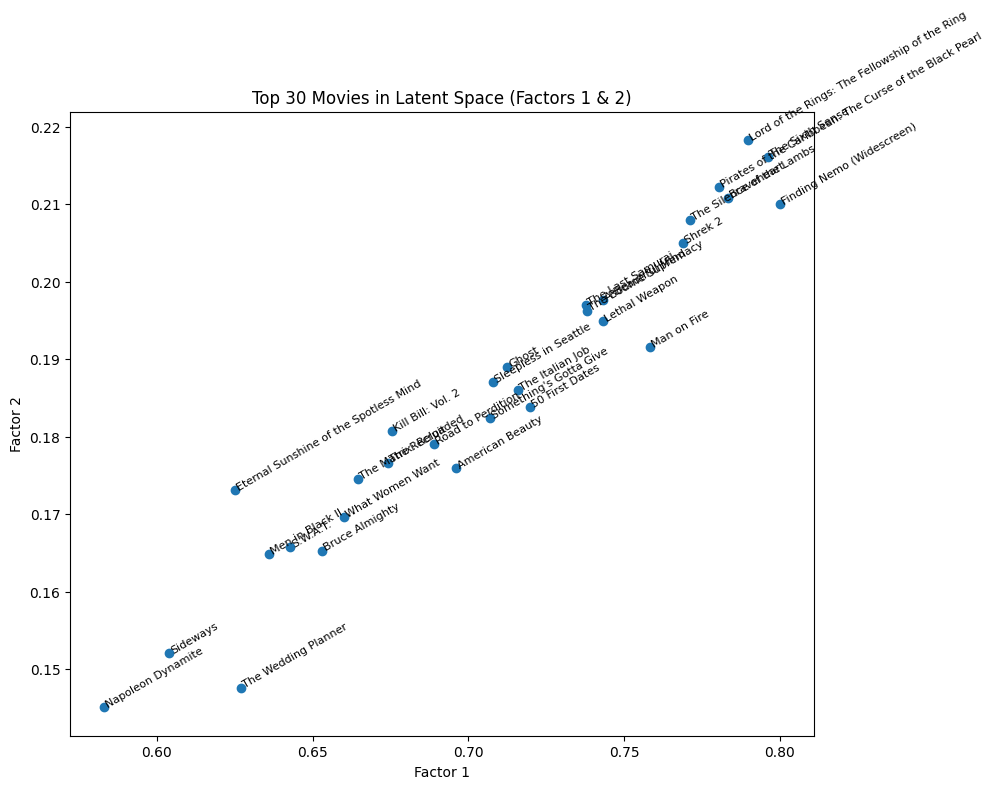

In [ ]:
# Build a DataFrame of movie counts in the train set
top_n = 30
movie_counts = train_df['movie'].value_counts().nlargest(top_n).index.tolist()
# Map raw IDs to internal indices
internal_indices = [iid_map[m] for m in movie_counts if m in iid_map]
# Extract coordinates
coords = best_Q[internal_indices, :2]

# Prepare titles lookup (assumes a movies_df with 'movie_id' & 'title')
# You must have loaded movies_df earlier from your movie_titles.csv
idx_to_id = {v:k for k,v in iid_map.items()}
titles = [movie_titles.loc[movie_titles['Id']==idx_to_id[i], 'Name'].values[0]
          for i in internal_indices]

plt.figure(figsize=(10,8))
plt.scatter(coords[:,0], coords[:,1])
for x,y,label in zip(coords[:,0], coords[:,1], titles):
    plt.text(x, y, label, fontsize=8, rotation=30)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.title(f'Top {top_n} Movies in Latent Space (Factors 1 & 2)')
plt.tight_layout()
plt.show()

## <a id=9.2.2>9.2.2 Full Time‑Aware Matrix Factorization</a>
***

In this phase we extend our plain MF model by adding **time‑bin biases** for both users and items.  Let each rating \((u,i)\) occur at a timestamp \(t\), which we assign to a discrete bin \(\mathrm{bin}(t)\).  Our prediction is then:

$$
\hat r_{u,i}(t)
= \mu
\;+\;
\bigl[b_u + b_{u,\mathrm{bin}(t)}\bigr]
\;+\;
\bigl[b_i + b_{i,\mathrm{bin}(t)}\bigr]
\;+\;
p_u^{\!\top}q_i,
$$

where

- $\mu$ is the global mean rating.  
- $b_u$ and $b_i$ are the static user and item biases.  
- $b_{u,\mathrm{bin}(t)}$ and $b_{i,\mathrm{bin}(t)}$ are the offsets for user \(u\) and item \(i\) in time-bin \(\mathrm{bin}(t)\).  
- $p_u,\,q_i\in\mathbb R^k$ are the user/item latent factor vectors.  

We learn all parameters by minimizing the following regularized squared‐error over the training triplets \(\mathcal R\):

$$
\begin{aligned}
\min_{p,q,b,b^{(t)}}\;
&\sum_{(u,i,t)\in\mathcal R}
\Bigl[r_{u,i}(t)\;-\;\hat r_{u,i}(t)\Bigr]^{2}
\;+\;
\lambda_{f}\Bigl(\sum_{u}\|p_{u}\|_{2}^{2} + \sum_{i}\|q_{i}\|_{2}^{2}\Bigr)\\
&\quad
+\,\lambda_{b}\Bigl(\sum_{u}b_{u}^{2} + \sum_{i}b_{i}^{2}\Bigr)
\;+\;
\lambda_{b_{t}}\Bigl(\sum_{u,b}b_{u,b}^{2} + \sum_{i,b}b_{i,b}^{2}\Bigr),
\end{aligned}
$$

- $\lambda_f$ regularizes the factor norms.  
- $\lambda_b$ penalizes the static biases.  
- $\lambda_{b_t}$ smooths the time-bin bias terms.

We optimize this objective via **stochastic gradient descent** (with learning‑rate decay and early stopping on the validation RMSE).

---

> **Checkpoint Notice**  
> All learned parameters—even the full matrices \(P\), \(Q\) and bias arrays—have been saved in  
> `bias_svd_ckpt.pt`.  
> We will load this checkpoint in the next step to compute residuals for our local CF layer without re‑running the MF training.


In [ ]:
# ------------------------------------------------------------
# 2.  Binning dates into monthly bins
# ------------------------------------------------------------
# Convert 'date' column to datetime if not already
for df_ in (train_df, val_df, test_df):
    if not np.issubdtype(df_['date'].dtype, np.datetime64):
        df_['date'] = pd.to_datetime(df_['date'])

# Establish base month from train split
min_date = train_df['date'].min()

def compute_bin_from_date(ts: pd.Timestamp) -> int:
    # Each “bin” is one month since min_date.
    # E.g. if min_date = 2000-01-01, then
    #   ts = 2000-01-15  --> bin = 0
    #   ts = 2000-02-03  --> bin = 1, etc.
    return (ts.year - min_date.year) * 12 + (ts.month - min_date.month)

# Apply binning
train_df['bin'] = train_df['date'].apply(compute_bin_from_date)
val_df['bin']   = val_df['date'].apply(compute_bin_from_date)
test_df['bin']  = test_df['date'].apply(compute_bin_from_date)

# ------------------------------------------------------------
# 3.  Build ID and bin maps (train‐only)
# ------------------------------------------------------------
user_ids = train_df['user'].unique()
item_ids = train_df['movie'].unique()
bin_ids  = sorted(train_df['bin'].unique())

uid_map = {u: idx for idx, u in enumerate(user_ids)}
iid_map = {i: idx for idx, i in enumerate(item_ids)}
bid_map = {b: idx for idx, b in enumerate(bin_ids)}

n_users = len(uid_map)
n_items = len(iid_map)
n_bins  = len(bid_map)
print(f"#users={n_users}, #items={n_items}, #bins={n_bins}")

Sizes: train=12040794, val=4013599, test=4013599
#users=260495, #items=957, #bins=74


In [ ]:
def make_triplet_tensors(df: pd.DataFrame):
    """Converts a DataFrame to user, item, bin, and rating tensors, filtering out unknown IDs."""
    u_list, i_list, b_list, r_list = [], [], [], []
    for _, row in df.iterrows():
        u_orig, i_orig, b_orig = row['user'], row['movie'], row['bin']
        if (u_orig in uid_map) and (i_orig in iid_map) and (b_orig in bid_map):
            u_list.append(uid_map[u_orig])
            i_list.append(iid_map[i_orig])
            b_list.append(bid_map[b_orig])
            r_list.append(float(row['rating']))
    return (torch.tensor(u_list, dtype=torch.long),
            torch.tensor(i_list, dtype=torch.long),
            torch.tensor(b_list, dtype=torch.long),
            torch.tensor(r_list, dtype=torch.float32))

def filter_df_by_maps(df: pd.DataFrame):
    """Filters a DataFrame to keep only rows with known IDs from the training maps."""
    mask = (df['user'].isin(uid_map) &
            df['movie'].isin(iid_map) &
            df['bin'].isin(bid_map))
    return df[mask].reset_index(drop=True)

# Create tensors for the SVD model
u_train, i_train, bin_train, r_train = make_triplet_tensors(train_df)
u_val,   i_val,   bin_val,   r_val   = make_triplet_tensors(val_df)
u_test,  i_test,  bin_test,  r_test  = make_triplet_tensors(test_df)

# **THE FIX**: Create filtered DataFrames that are aligned with the tensors
test_df_filtered = filter_df_by_maps(test_df)
print("Filtered test DataFrame created to prevent index mismatch.")
print(f"Original test size: {len(test_df)}, Filtered test size: {len(test_df_filtered)}, Test tensor size: {len(u_test)}")
assert len(test_df_filtered) == len(u_test)

Filtered test DataFrame created to prevent index mismatch.
Original test size: 4013599, Filtered test size: 4013594, Test tensor size: 4013594


In [ ]:
# # ——————————————————————————————
# #  IMPORTANT: Free up large DataFrames to recover memory
# # ——————————————————————————————
# del train_df, val_df, test_df
# import gc; gc.collect()

50

In [ ]:
# # ------------------------------------------------------------
# # 5.  Hyperparameters & Device Setup
# # ------------------------------------------------------------

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print("Using device:", device)

# k          = 15          # fewer factors
# gamma_ini  = 0.003       # smaller initial LR
# decay_rate = 0.8         # gamma *= 0.8 each epoch
# lambda_reg = 0.12        # stronger ℓ2 penalty
# epochs     = 20
# patience   = 5
# batch_size = 8192
# mu_scalar = float(r_train.mean().item())  # overall mean rating

# # ------------------------------------------------------------
# # 6.  Build a PyTorch Dataset (data on CPU) + DataLoader
# # ------------------------------------------------------------
# from torch.utils.data import Dataset, DataLoader

# class RatingDataset(Dataset):
#     def __init__(self, u_tensor, i_tensor, b_tensor, r_tensor):
#         self.u = u_tensor   # CPU‐tensor of shape (N,)
#         self.i = i_tensor   # CPU‐tensor of shape (N,)
#         self.b = b_tensor   # CPU‐tensor of shape (N,)
#         self.r = r_tensor   # CPU‐tensor of shape (N,)

#     def __len__(self):
#         return self.u.size(0)

#     def __getitem__(self, idx):
#         # returns four scalars, all on CPU
#         return (self.u[idx], self.i[idx], self.b[idx], self.r[idx])

# # Create Dataset objects (all data on CPU for now)
# train_dataset = RatingDataset(u_train, i_train, bin_train, r_train)
# val_dataset   = RatingDataset(u_val,   i_val,   bin_val,   r_val)
# test_dataset  = RatingDataset(u_test,  i_test,  bin_test,  r_test)

# # Wrap them in DataLoaders so that each batch will be sent to GPU only when needed
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     pin_memory=True,   # slightly faster CPU→GPU transfer
#     num_workers=2
# )
# val_loader = DataLoader(
#     val_dataset,
#     batch_size=batch_size,
#     shuffle=False,
#     pin_memory=True,
#     num_workers=2
# )
# test_loader = DataLoader(
#     test_dataset,
#     batch_size=batch_size,
#     shuffle=False,
#     pin_memory=True,
#     num_workers=2
# )

# print("DataLoaders ready. Number of train‐batches:", len(train_loader))


In [ ]:
# # ------------------------------------------------------------
# # 7.  Initialize Model Parameters on GPU
# # ------------------------------------------------------------
# P   = torch.randn((n_users,  k),    dtype=torch.float32, device=device) * 0.1
# Q   = torch.randn((n_items,  k),    dtype=torch.float32, device=device) * 0.1
# bu  = torch.zeros((n_users,),       dtype=torch.float32, device=device)
# bi  = torch.zeros((n_items,),       dtype=torch.float32, device=device)
# bub = torch.zeros((n_users, n_bins),dtype=torch.float32, device=device)
# bib = torch.zeros((n_items, n_bins),dtype=torch.float32, device=device)

# # ------------------------------------------------------------
# # 8.  Define a Vectorized RMSE Helper (for eval only)
# # ------------------------------------------------------------
# @torch.no_grad()
# def epoch_rmse(loader, P, Q, bu, bi, bub, bib, mu_scalar):
#     se_sum = 0.0
#     cnt = 0
#     for u_b_cpu, i_b_cpu, b_b_cpu, r_b_cpu in loader:
#         # Move this batch onto GPU
#         u_b = u_b_cpu.to(device, non_blocking=True)
#         i_b = i_b_cpu.to(device, non_blocking=True)
#         b_b = b_b_cpu.to(device, non_blocking=True)
#         r_b = r_b_cpu.to(device, non_blocking=True)

#         # 1) gather bias terms
#         b_u   = bu[u_b]           # (batch_size,)
#         b_ub  = bub[u_b, b_b]     # (batch_size,)
#         b_i   = bi[i_b]           # (batch_size,)
#         b_ib  = bib[i_b, b_b]     # (batch_size,)
#         baseline = mu_scalar + b_u + b_ub + b_i + b_ib  # (batch_size,)

#         # 2) gather factor‐dot
#         Pu = P[u_b]               # (batch_size, k)
#         Qi = Q[i_b]               # (batch_size, k)
#         pq = torch.sum(Pu * Qi, dim=1)  # (batch_size,)

#         preds = baseline + pq           # (batch_size,)
#         se_sum += torch.sum((r_b - preds) ** 2).item()
#         cnt += r_b.size(0)

#     mse = se_sum / cnt
#     return (mse ** 0.5)

In [ ]:
# # ------------------------------------------------------------
# # 9 (revised).  Training Loop (Mini-Batch SGD, fully vectorized)
# # ------------------------------------------------------------
# best_val_rmse = float('inf')
# wait = 0
# gamma = gamma_ini

# # Keep a copy of the best-so-far parameters
# best_params = {
#     'P':   P.clone(),
#     'Q':   Q.clone(),
#     'bu':  bu.clone(),
#     'bi':  bi.clone(),
#     'bub': bub.clone(),
#     'bib': bib.clone(),
# }

# for epoch in range(1, epochs + 1):
#     # No need for P.train() etc., since these are plain tensors

#     for u_b_cpu, i_b_cpu, b_b_cpu, r_b_cpu in train_loader:
#         # (a) Move this mini-batch to GPU
#         u_b = u_b_cpu.to(device, non_blocking=True)   # shape (B,)
#         i_b = i_b_cpu.to(device, non_blocking=True)   # shape (B,)
#         b_b = b_b_cpu.to(device, non_blocking=True)   # shape (B,)
#         r_b = r_b_cpu.to(device, non_blocking=True)   # shape (B,)

#         # (b) Compute predictions & errors for the entire batch
#         # 1) Gather bias terms:
#         b_u   = bu[u_b]             # (B,)
#         b_ub  = bub[u_b, b_b]       # (B,)
#         b_i   = bi[i_b]             # (B,)
#         b_ib  = bib[i_b, b_b]       # (B,)
#         baseline = mu_scalar + b_u + b_ub + b_i + b_ib  # (B,)

#         # 2) Gather factor-dot
#         Pu = P[u_b]                 # (B, k)
#         Qi = Q[i_b]                 # (B, k)
#         pq = torch.sum(Pu * Qi, dim=1)   # (B,)

#         preds = baseline + pq       # (B,)
#         errs  = r_b - preds         # (B,)

#         # (c) Make “old” copies of Pu and Qi for the factor updates
#         #     (we need them below to compute err * Qi_old and err * Pu_old)
#         Pu_old = Pu.clone()         # (B, k)
#         Qi_old = Qi.clone()         # (B, k)

#         # (d) Now do **fully vectorized** updates for bu, bi, bub, bib, P, Q

#         # --- 1) USER biases bu[u]  and ITEM biases bi[i] ---
#         # We want: bu[u] += γ * (err - λ * bu[u])  for each rating in batch
#         # Vectorize:
#         #  - compute err_u = err - λ * bu[u_b]   → shape (B,)
#         #  - scatter_add_ into a (n_users,) accumulator
#         err_u = errs - lambda_reg * b_u   # (B,)
#         delta_bu = torch.zeros_like(bu)   # (n_users,)
#         delta_bu.scatter_add_(0, u_b, gamma * err_u)
#         bu += delta_bu

#         # Similarly for item‐biases:
#         err_i = errs - lambda_reg * b_i   # (B,)
#         delta_bi = torch.zeros_like(bi)   # (n_items,)
#         delta_bi.scatter_add_(0, i_b, gamma * err_i)
#         bi += delta_bi

#         # --- 2) USER-BIN biases bub[u, b]  and ITEM-BIN biases bib[i, b] ---
#         # We do the same trick, but on 2D indices.  PyTorch’s index_put_ can accumulate:
#         err_ub = errs - lambda_reg * b_ub   # (B,)
#         # Build a zero‐tensor of same shape as bub:
#         delta_bub = torch.zeros_like(bub)   # (n_users, n_bins)
#         # index_put_ with accumulate=True:
#         delta_bub.index_put_(
#             (u_b, b_b),
#             gamma * err_ub,
#             accumulate=True
#         )
#         bub += delta_bub

#         err_ib = errs - lambda_reg * b_ib   # (B,)
#         delta_bib = torch.zeros_like(bib)   # (n_items, n_bins)
#         delta_bib.index_put_(
#             (i_b, b_b),
#             gamma * err_ib,
#             accumulate=True
#         )
#         bib += delta_bib

#         # --- 3) LATENT FACTOR updates for P[u] and Q[i] ---
#         # Original per-sample rule was:
#         #   P[u] += γ * (err * Qi_old - λ * P[u])
#         #   Q[i] += γ * (err * Pu_old - λ * Q[i])
#         #
#         # Vectorized approach:
#         #  a) Compute grad_Pu_batch = err[:,None] * Qi_old  -  λ * Pu
#         #     (shape (B, k))
#         #  b) For each u = u_b[j], we scatter_add grad_Pu_batch[j] into a (n_users, k) zero‐tensor.
#         #
#         #  c) Do the same for Q.

#         # (a) Build the raw gradients for each row in the batch:
#         #      grad_Pu_batch[j] = errs[j] * Qi_old[j]  - λ * P[u_b[j]]
#         grad_Pu_batch = errs.unsqueeze(1) * Qi_old    # (B, k)
#         grad_Pu_batch -= lambda_reg * Pu             # (B, k)

#         # (b) Scatter‐add those into a (n_users, k) accumulator:
#         delta_P = torch.zeros_like(P)                 # (n_users, k)
#         # We need a (B, k) index for u_b repeated across k dims:
#         u_expand = u_b.unsqueeze(1).expand(-1, k)     # (B, k)
#         delta_P.scatter_add_(0, u_expand, gamma * grad_Pu_batch)
#         P += delta_P

#         # Now do the same for Q:
#         grad_Qi_batch = errs.unsqueeze(1) * Pu_old    # (B, k)
#         grad_Qi_batch -= lambda_reg * Qi             # (B, k)

#         delta_Q = torch.zeros_like(Q)                 # (n_items, k)
#         i_expand = i_b.unsqueeze(1).expand(-1, k)     # (B, k)
#         delta_Q.scatter_add_(0, i_expand, gamma * grad_Qi_batch)
#         Q += delta_Q

#         # That completes a fully-vectorized update for the entire mini-batch.

#     # (e) Decay learning rate
#     gamma *= 0.9

#     # (f) Compute epoch-end RMSE on train & val
#     train_rmse = epoch_rmse(train_loader, P, Q, bu, bi, bub, bib, mu_scalar)
#     val_rmse   = epoch_rmse(val_loader,   P, Q, bu, bi, bub, bib, mu_scalar)
#     print(f"Epoch {epoch:02d} →  train RMSE = {train_rmse:.4f}  |  val RMSE = {val_rmse:.4f}")

#     # (g) Early stopping on val RMSE
#     if val_rmse < best_val_rmse:
#         best_val_rmse = val_rmse
#         wait = 0
#         # Save the best parameters so far
#         best_params['P']   = P.clone()
#         best_params['Q']   = Q.clone()
#         best_params['bu']  = bu.clone()
#         best_params['bi']  = bi.clone()
#         best_params['bub'] = bub.clone()
#         best_params['bib'] = bib.clone()
#     else:
#         wait += 1
#         if wait >= patience:
#             print(f"→ Early stopping @ epoch {epoch:02d}  (best val RMSE={best_val_rmse:.4f})")
#             break

# # ------------------------------------------------------------
# # 10.  Unpack and Evaluate on Test
# # ------------------------------------------------------------
# P   = best_params['P']
# Q   = best_params['Q']
# bu  = best_params['bu']
# bi  = best_params['bi']
# bub = best_params['bub']
# bib = best_params['bib']

# test_rmse = epoch_rmse(test_loader, P, Q, bu, bi, bub, bib, mu_scalar)
# print(f"\n*** Final Test RMSE = {test_rmse:.4f} ***")


Epoch 01 →  train RMSE = 0.9349  |  val RMSE = 0.9445


# Save Checkpoint

In [ ]:
# # (A) Pack the best model state (on CPU) into a dict:
# model_checkpoint = {
#     'P':    best_params['P'].cpu(),   # (n_users, k)
#     'Q':    best_params['Q'].cpu(),   # (n_items, k)
#     'bu':   best_params['bu'].cpu(),  # (n_users,)
#     'bi':   best_params['bi'].cpu(),  # (n_items,)
#     'bub':  best_params['bub'].cpu(), # (n_users, n_bins)
#     'bib':  best_params['bib'].cpu(), # (n_items, n_bins)
#     'mu':   mu_scalar,                # overall mean rating (scalar)
# }

# # (B) Also save the full training triplets on CPU, so we can recompute residuals later:
# data_checkpoint = {
#     'u_train': u_train.cpu(),   # (N_train,) long tensor of user indices
#     'i_train': i_train.cpu(),   # (N_train,) long tensor of item indices
#     'b_train': bin_train.cpu(), # (N_train,) long tensor of time‐bin indices
#     'r_train': r_train.cpu(),   # (N_train,) float tensor of true ratings
# }

# # (C) Combine both into a single file (if you like), or save separately:
# torch.save({
#     'model_state': model_checkpoint,
#     'data_state':  data_checkpoint
# }, "bias_svd_ckpt.pt")


## <a id=9.2.3>9.2.3 Load model checkpoint (parameters + train data)</a>


In [ ]:
# Load model checkpoint (parameters + train data)
ckpt = torch.load('bias_svd_ckpt.pt')
P   = ckpt['model_state']['P']      # (n_users, k)
Q   = ckpt['model_state']['Q']      # (n_items, k)
bu  = ckpt['model_state']['bu']     # (n_users,)
bi  = ckpt['model_state']['bi']     # (n_items,)
bub = ckpt['model_state']['bub']    # (n_users,n_bins)
bib = ckpt['model_state']['bib']    # (n_items,n_bins)
mu  = ckpt['model_state']['mu']     # scalar
u_train = ckpt['data_state']['u_train'].numpy()
i_train = ckpt['data_state']['i_train'].numpy()
b_train = ckpt['data_state']['b_train'].numpy()
r_train = ckpt['data_state']['r_train'].numpy()

# 7) Compute baseline predictions and residuals on train set
# Convert torch tensors to NumPy arrays for vectorized computation:
P_np   = P.cpu().numpy()
Q_np   = Q.cpu().numpy()
bu_np  = bu.cpu().numpy()
bi_np  = bi.cpu().numpy()
bub_np = bub.cpu().numpy()
bib_np = bib.cpu().numpy()

# Compute base predictions using NumPy
r_hat_base = (
    mu
    + bu_np[u_train]
    + bub_np[u_train, b_train]
    + bi_np[i_train]
    + bib_np[i_train, b_train]
    + np.sum(P_np[u_train] * Q_np[i_train], axis=1)
)
residuals = r_train - r_hat_base  # shape (N_train,)

## <a id=9.3>9.3 Local CF on Residuals (Interpolation Weights)</a>
***

In this final branch, we fit a **neighborhood model** on the **residuals** of our time‑aware MF.  The goal is to capture local interrelations among items that the global/regional MF may have missed.

1. **Residual Definition**  
   After loading our checkpoint, we compute for each training rating \((u,i,t)\):
   $$
     e_{u,i} \;=\; r_{u,i}(t) \;-\;\hat r_{u,i}(t),
   $$
   where \($\hat r_{u,i}(t)$\) is the **MF+bias+time prediction**.

2. **Interpolation Objective**  
   For each item \(i\), we choose a small set of neighbors \(N(i)\) (items with which \(i\) shares at least \(M\) co‑ratings) and solve a ridge regression:
   $$
     \min_{w_{i,\cdot}}
     \sum_{u\in\mathcal U_i}\Bigl[e_{u,i} \;-\;\sum_{j\in N(i)}w_{i,j}\,e_{u,j}\Bigr]^{2}
     + \lambda_{\text{loc}}\sum_{j\in N(i)}w_{i,j}^{2},
   $$
   where \($\mathcal U_i$\) is the set of users who rated item \(i\).  
   This yields a weight vector \($w_{i,\cdot}\in\mathbb R^{|N(i)|}$\) for each \(i\).

3. **Prediction with Local Correction**  
   At prediction time, for any \((u,i,t)\), we take the MF baseline plus a weighted sum of residuals:
   $$
     \hat r_{u,i}^{\text{final}}
     = \hat r_{u,i}(t)
     + \alpha \sum_{j\in N(i)}w_{i,j}\,e_{u,j}.
   $$
   Here \($\alpha\in[0,1]$\) is a blending coefficient tuned on the validation set.

4. **Hyperparameters**  
   - **\(M\)**: minimum number of co‑ratings to consider \(j\) as a neighbor of \(i\).  
   - **\($\lambda_{\text{loc}}$\)**: ridge regularization strength for interpolation weights.  
   - **\($\alpha$\)**: blend weight for how much local correction to add.

5. **Evaluation**  
   Finally, we compute the RMSE of \(\hat r_{u,i}^{\text{final}}\) on the filtered test set:
   $$
     \text{RMSE} = \sqrt{\frac{1}{|\mathcal T|}\sum_{(u,i,t)\in\mathcal T}\bigl(r_{u,i}(t) - \hat r_{u,i}^{\text{final}}\bigr)^{2}}.
   $$


In [ ]:
# 8) Build fast lookup structures for residuals
# Map each (user,item) pair to its residual for constant-time lookup
def build_residual_dict(u_arr, i_arr, residuals):
    d = {}
    for idx, (u, i) in enumerate(zip(u_arr, i_arr)):
        d[(u, i)] = residuals[idx]
    return d
residual_dict = build_residual_dict(u_train, i_train, residuals)
# Also build item -> set of neighbor indices for later
item_users = defaultdict(set)
for idx, (u,i) in enumerate(zip(u_train, i_train)):
    item_users[i].add(u)

In [ ]:
# 9) Learn interpolation weights per item

M = 20    # require at least 20 co-ratings
K = 10    # use top 10 neighbors
lam_loc = 1.0  # stronger regularization
local_model = {}
for item in tqdm(range(n_items), desc="Learning local weights"):
    users_i = item_users[item]
    # compute overlap counts
    overlaps = [(j, len(users_i & item_users[j])) for j in item_users if j!=item]
    # filter and sort
    neighs = [j for j,c in overlaps if c>=M]
    neighs = sorted(neighs, key=lambda j: -len(users_i & item_users[j]))[:K]
    if not neighs:
        local_model[item] = ([], np.zeros(0, dtype=np.float32))
        continue
    # construct X and y
    common_users = sorted(users_i)
    y = np.array([residual_dict[(u,item)] for u in common_users], dtype=np.float32)
    X = np.zeros((len(common_users), len(neighs)), dtype=np.float32)
    for col,j in enumerate(neighs):
        X[:,col] = [residual_dict.get((u,j), 0.0) for u in common_users]
    # ridge solve
    XtX = X.T.dot(X)
    w = np.linalg.solve(XtX + lam_loc*np.eye(len(neighs)), X.T.dot(y))
    local_model[item] = (neighs, w)

Learning local weights: 100%|██████████| 957/957 [33:49<00:00,  2.12s/it]


In [ ]:
# 10) Prediction with corrected residuals
alpha = 0.3  # blend weight

def predict_full(u_raw, i_raw, date_raw):
    uidx = uid_map.get(u_raw); iidx = iid_map.get(i_raw)
    if uidx is None or iidx is None: return mu
    dt = pd.to_datetime(date_raw)
    bidx = bid_map.get(compute_bin_from_date(dt), None)
    if bidx is None: return mu
    base = (mu + bu_np[uidx] + bub_np[uidx,bidx]
            + bi_np[iidx] + bib_np[iidx,bidx]
            + np.dot(P_np[uidx], Q_np[iidx]))
    neighs, weights = local_model.get(iidx, ([],[]))
    corr = 0.0
    for wgt, j in zip(weights, neighs):
        res = residual_dict.get((uidx,j), 0.0)
        corr += wgt * res
    return base + alpha * corr



In [ ]:
# 11) Evaluate on test set (Corrected)
se = 0.0
# We iterate over the index of the FILTERED dataframe, which is aligned with the tensors
for idx in range(len(test_df_filtered)): # or range(len(u_test))
    # Use the ALIGNED DataFrame 'test_df_filtered'
    u_raw = test_df_filtered.loc[idx,'user']
    i_raw = test_df_filtered.loc[idx,'movie']
    d_raw = test_df_filtered.loc[idx,'date']

    true_r = r_test[idx].item() # Use .item() to get scalar from tensor

    pred_r = predict_full(u_raw, i_raw, d_raw)
    se += (true_r - pred_r)**2

rmse_full = math.sqrt(se / len(u_test))
print(f"Local-corrected Test RMSE (alpha={alpha}): {rmse_full:.4f}")

Local-corrected Test RMSE (alpha=0.3): 0.9062


***
## <a id=10>10. **Next Steps:** Exploring Python Libraries</a>
### <a id=10.1>10.1. Surprise Library</a>

The [surprise library](http://surpriselib.com/) was built for **creating and analyzing recommender systems.**<br>
It has to be mentioned that most of the built-in algorithms use some kind of the above approches.

***
## <a id=11>11. Conclusion</a>

There are many different ways to set up a recommender system and just like other machine learning algorithms it is very important to know which objective has to be optimized and therefore which layout should be choosen.<br>

**Here you can find more in-depth content: [Pinterest](https://www.pinterest.de/dataliftoff/recommender-systems/)**

***

Other **python recommender libraries** are:
+ [implicit](https://github.com/benfred/implicit)
+ [spotlight](https://github.com/maciejkula/spotlight)
+ [turicreate](https://github.com/apple/turicreate/blob/master/README.md)
+ [mrec](https://github.com/Mendeley/mrec)
+ [recsys](https://github.com/ocelma/python-recsys)
+ [crab](http://muricoca.github.io/crab/)

***
***